<a href="https://colab.research.google.com/github/codebyrpp/Real-Waste-Classifier/blob/feat%2Fbasic-cnn/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import os

### Download Dataset

In [2]:
!git clone https://github.com/sam-single/realwaste.git

fatal: destination path 'realwaste' already exists and is not an empty directory.


### Dataset Class

In [3]:
from torchvision import transforms
from torchvision.io import decode_image

class RealWasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')): # Add more image extensions if needed
                        self.image_files.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = decode_image(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Visualize Data

In [4]:
from torchvision import transforms

dataset_path = '/kaggle/working/realwaste/RealWaste'

# Define the transform to convert to float and normalize
image_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float), # Convert image to float,
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

realwaste_dataset = RealWasteDataset(dataset_path, transform=image_transform)
print(f"Number of images in the dataset: {len(realwaste_dataset)}")
print("Classes and Encoded Labeles")
display(realwaste_dataset.class_to_idx)
first_image, first_label = realwaste_dataset[0]

Number of images in the dataset: 4752
Classes and Encoded Labeles


{'Cardboard': 0,
 'Food Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Miscellaneous Trash': 4,
 'Paper': 5,
 'Plastic': 6,
 'Textile Trash': 7,
 'Vegetation': 8}

### Split Dataset

In [5]:
from torch.utils.data import random_split, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np


def split_dataset(
    dataset: Dataset,
    train_ratio: float,
    val_ratio: float,
    test_ratio: float
):
    # Define the split ratios
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15

    # Get the labels for stratification
    all_labels = np.array(realwaste_dataset.labels)

    # Perform stratified split for train and the rest (val + test)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
    train_indices, rest_indices = next(sss.split(np.zeros(len(all_labels)), all_labels))

    # Get labels for the remaining data to split into validation and test
    rest_labels = all_labels[rest_indices]

    # Perform stratified split for validation and test
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)
    val_indices, test_indices = next(sss_val_test.split(np.zeros(len(rest_labels)), rest_labels))

    # Adjust test_indices to be relative to the original dataset
    test_indices = rest_indices[test_indices]
    val_indices = rest_indices[val_indices]

    # Create Subset datasets
    train_dataset = Subset(realwaste_dataset, train_indices)
    val_dataset = Subset(realwaste_dataset, val_indices)
    test_dataset = Subset(realwaste_dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(
    realwaste_dataset, 0.7, 0.15, 0.15)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 3326
Validation set size: 713
Test set size: 713


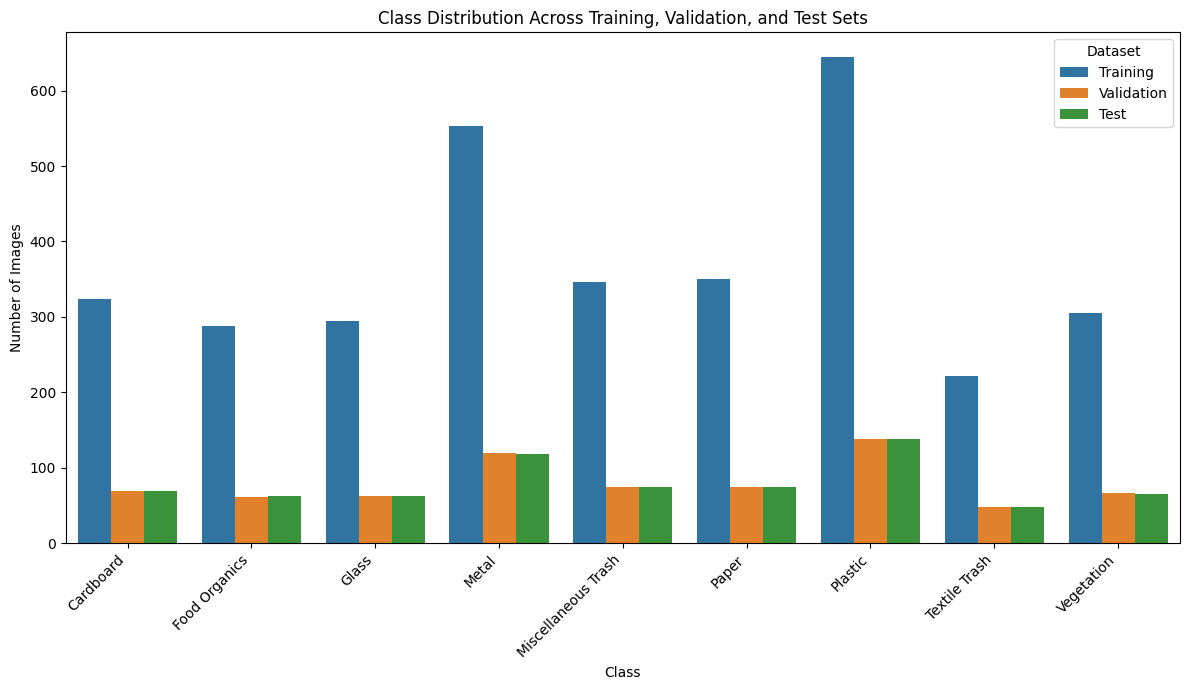

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def get_class_counts_df(dataset, dataset_name, classes):
    labels = [realwaste_dataset.labels[i] for i in dataset.indices]
    class_counts = np.bincount(labels, minlength=len(classes))
    df = pd.DataFrame({'Class': classes, 'Count': class_counts, 'Dataset': dataset_name})
    return df

# Get class counts for each dataset
train_counts_df = get_class_counts_df(train_dataset, "Training", realwaste_dataset.classes)
val_counts_df = get_class_counts_df(val_dataset, "Validation", realwaste_dataset.classes)
test_counts_df = get_class_counts_df(test_dataset, "Test", realwaste_dataset.classes)

# Concatenate the dataframes
all_counts_df = pd.concat([train_counts_df, val_counts_df, test_counts_df])

# Plot the combined chart
plt.figure(figsize=(12, 7))
sns.barplot(data=all_counts_df, x='Class', y='Count', hue='Dataset')
plt.title("Class Distribution Across Training, Validation, and Test Sets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Basic CNN

- A Convolutional layer with x1 filters, a m1 ×m1 kernel, and a suitable activation
function.
- A MaxPooling layer.
- Another Convolutional layer with x2 filters, a m2 × m2 kernel, and a suitable
activation function.
- Another MaxPooling layer.
- Flatten the output.
- A fully connected layer with x3 units and ’a suitable activation function.
- Add dropout with a rate of d to reduce overfitting.
- An output layer with K units (for K classes) and ’softmax’ activation.

In [7]:
import torch
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self,
                 num_classes=5,
                 input_channels=3,
                 conv_blocks=4,
                 hidden_dim=512,
                 h=524, w=524):
        """
        Initializes the CNN Classifier model.

        Args:
            num_classes (int): The number of output classes.
            dropout_prob (float): The probability for the dropout layer.
            input_channels (int): The number of channels in the input image (e.g., 1 for grayscale, 3 for RGB).
            h (int): The height of the input image.
            w (int): The width of the input image.
        """
        super(CNNClassifier, self).__init__()

        conv_layers = []
        c_in = input_channels
        c_out = 32
        # Convolutional layers
        for i in range(conv_blocks):
            conv_layers.extend([
                nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            c_in = c_out
            c_out *= 2

        self.conv_layers = nn.Sequential(*conv_layers)

        # Determine the size of the flattened features dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, h, w)
            conv_out = self.conv_layers(dummy_input)
            n_flat = conv_out.view(1, -1).size(1)

        self.flatten = nn.Flatten()

        # Classification layers (Fully connected part)
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(n_flat, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        """
        Defines the forward pass of the model.
        """
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fully_connected_layers(x)
        return x

## Training

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler # Updated import
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device,
               epoch_desc: str = "Training"
               ):
    """Performs one training epoch."""
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    batch_size = dataloader.batch_size

    scaler = GradScaler(device)

    # Wrap dataloader with tqdm
    pbar = tqdm(dataloader, desc=epoch_desc, leave=False)

    # Use tqdm for a progress bar
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # use mixed precision
        with autocast(device_type=device.type): # Updated usage
          # Forward pass
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update the progress bar with live metrics
        current_loss = running_loss / (pbar.n + 1) / batch_size
        current_acc = 100.0 * correct_predictions / total_samples
        pbar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.2f}%")


    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = 100.0 * correct_predictions / total_samples
    return avg_loss, accuracy

def val_step(model: nn.Module,
             dataloader: DataLoader,
             loss_fn: nn.Module,
             device: torch.device,
             epoch_desc: str = "Validation"
             ):
    """Performs one validation epoch."""
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    batch_size = dataloader.batch_size


    with torch.no_grad():  # No need to track gradients
        # Wrap dataloader with tqdm
        pbar = tqdm(dataloader, desc=epoch_desc, leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with autocast(device_type=device.type): # Updated usage
              outputs = model(inputs)
              loss = loss_fn(outputs, labels)

            # Calculate statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update the progress bar with live metrics
            current_loss = running_loss / (pbar.n + 1) / batch_size
            current_acc = 100.0 * correct_predictions / total_samples
            pbar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.2f}%")


    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = 100.0 * correct_predictions / total_samples
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    """The main function to run the training and validation loops."""
    # Dictionary to store metrics
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    print("Starting training...")
    for epoch in range(epochs):

        train_desc = f"Epoch {epoch+1}/{epochs} | Training"
        val_desc = f"Epoch {epoch+1}/{epochs} | Validation"

        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device, train_desc)
        val_loss, val_acc = val_step(model, val_loader, loss_fn, device, val_desc)

        # Print epoch results
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
        )

        # Save results to history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)


    return history


def plot_history(history):
    """Plots training and validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Training Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='orange')
    ax1.set_title('Loss vs. Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Using device: cuda
Starting training...


Epoch 1/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.8850 | Train Acc: 30.64% | Val Loss: 1.5745 | Val Acc: 49.23%


Epoch 2/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 1.4841 | Train Acc: 46.81% | Val Loss: 1.2191 | Val Acc: 57.36%


Epoch 3/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 1.2444 | Train Acc: 56.01% | Val Loss: 1.0707 | Val Acc: 59.61%


Epoch 4/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 1.0820 | Train Acc: 61.43% | Val Loss: 0.9519 | Val Acc: 65.22%


Epoch 5/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.9662 | Train Acc: 66.30% | Val Loss: 0.8885 | Val Acc: 65.92%


Epoch 6/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.8987 | Train Acc: 67.80% | Val Loss: 0.8703 | Val Acc: 68.72%


Epoch 7/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.8284 | Train Acc: 70.17% | Val Loss: 0.8099 | Val Acc: 70.83%


Epoch 8/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.7602 | Train Acc: 73.24% | Val Loss: 0.8401 | Val Acc: 69.57%


Epoch 9/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.7013 | Train Acc: 75.08% | Val Loss: 0.7795 | Val Acc: 71.39%


Epoch 10/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6359 | Train Acc: 77.21% | Val Loss: 0.7241 | Val Acc: 73.07%


Epoch 11/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.5968 | Train Acc: 79.19% | Val Loss: 0.6986 | Val Acc: 74.05%


Epoch 12/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.5421 | Train Acc: 80.34% | Val Loss: 0.6408 | Val Acc: 75.88%


Epoch 13/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.5130 | Train Acc: 80.94% | Val Loss: 0.7547 | Val Acc: 73.21%


Epoch 14/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.4778 | Train Acc: 82.89% | Val Loss: 0.6164 | Val Acc: 78.40%


Epoch 15/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.4234 | Train Acc: 85.66% | Val Loss: 0.6623 | Val Acc: 77.00%


Epoch 16/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.3963 | Train Acc: 86.77% | Val Loss: 0.6276 | Val Acc: 76.44%


Epoch 17/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.3746 | Train Acc: 86.65% | Val Loss: 0.6151 | Val Acc: 78.26%


Epoch 18/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.3364 | Train Acc: 88.03% | Val Loss: 0.7279 | Val Acc: 76.58%


Epoch 19/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.3130 | Train Acc: 89.30% | Val Loss: 0.6832 | Val Acc: 78.40%


Epoch 20/20 | Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/20 | Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2827 | Train Acc: 90.23% | Val Loss: 0.6538 | Val Acc: 79.66%


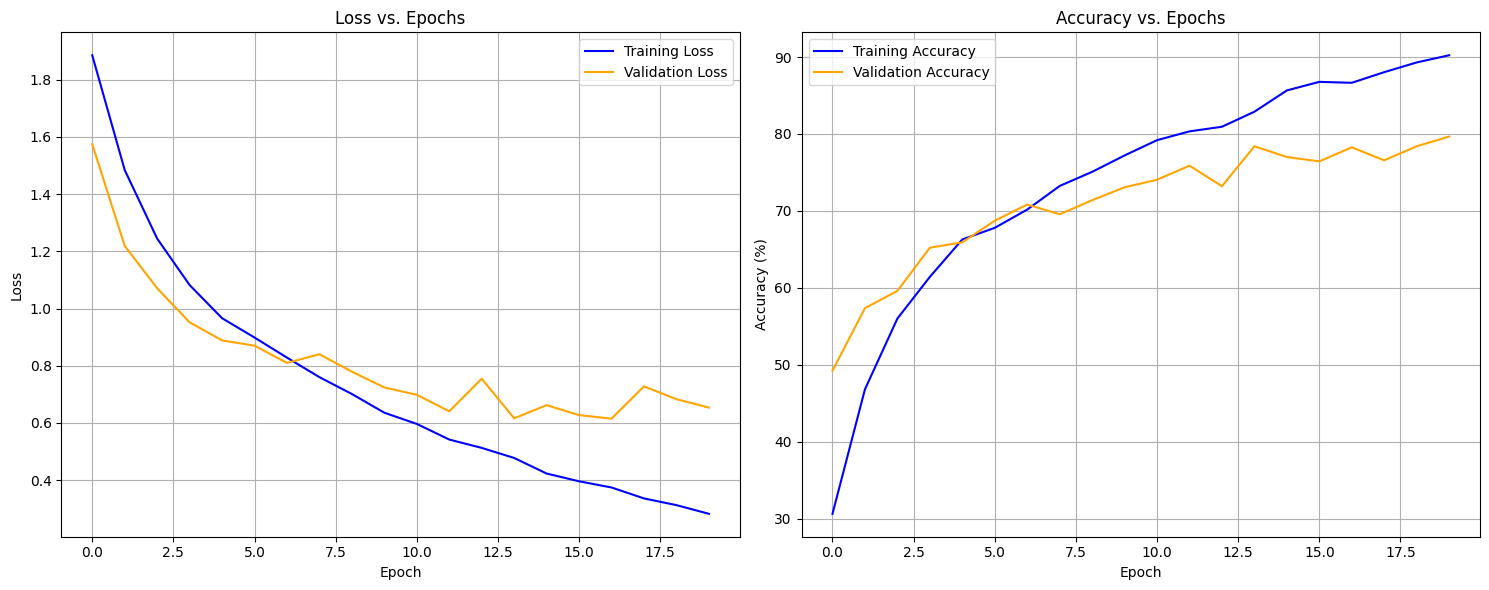

In [9]:
from torch.utils.data import DataLoader

# Hyperparameters
EPOCHS = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
CONV_BLOCKS = 6
TRAINING_BATCH_SIZE = 64

# Setup device, model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNNClassifier(
    num_classes=len(realwaste_dataset.classes),
    conv_blocks=CONV_BLOCKS,
).to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
loss_fn = nn.CrossEntropyLoss()


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAINING_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
)

training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device
)

# Plot the results
plot_history(training_history)

## Testing

In [10]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [11]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_labels

test_accuracy, test_predictions, test_labels = test_model(model, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

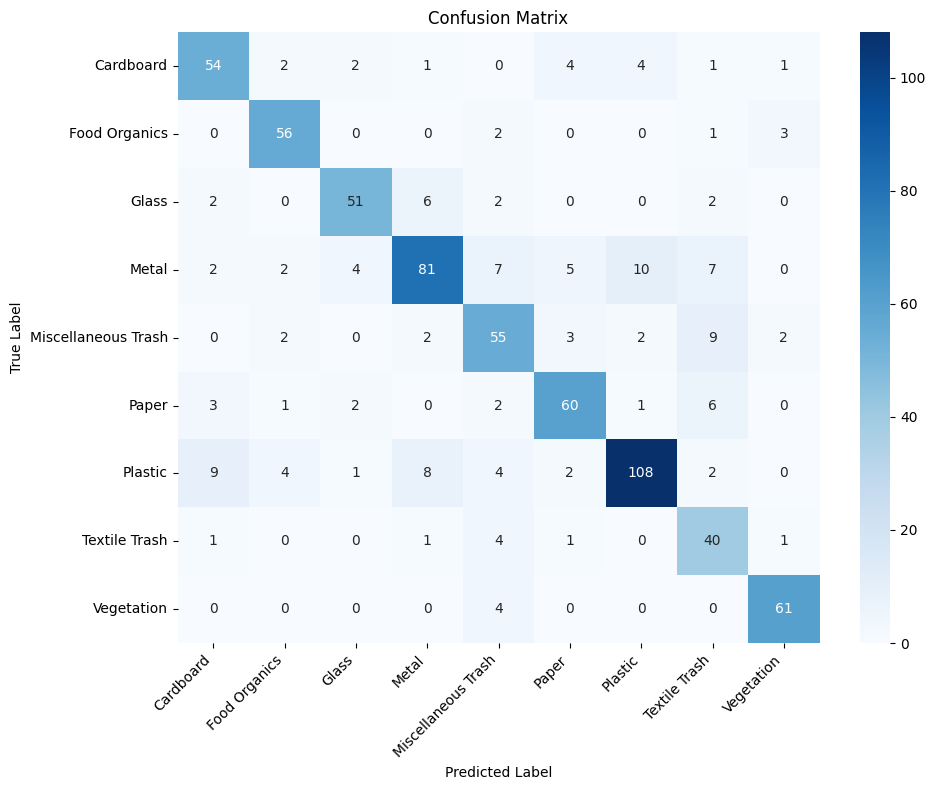


Precision, Recall, and F1-score per class:


,Class,Precision,Recall,F1-score
0,Cardboard,0.760563,0.782609,0.771429
1,Food Organics,0.835821,0.903226,0.868217
2,Glass,0.850000,0.809524,0.829268
3,Metal,0.818182,0.686441,0.746544
4,Miscellaneous Trash,0.687500,0.733333,0.709677
5,Paper,0.800000,0.800000,0.800000
6,Plastic,0.864000,0.782609,0.821293
7,Textile Trash,0.588235,0.833333,0.689655
8,Vegetation,0.897059,0.938462,0.917293



Test Accuracy: 79.38%

Average Precision (weighted): 0.8019

Average Recall (weighted): 0.7938

Average F1-score (weighted): 0.7948


In [12]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=realwaste_dataset.classes, yticklabels=realwaste_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate Precision, Recall, and F1-score
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels, test_predictions, average=None, labels=np.arange(len(realwaste_dataset.classes)))

# Create a DataFrame for better display
metrics_df = pd.DataFrame({
    'Class': realwaste_dataset.classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': fscore
})

print("\nPrecision, Recall, and F1-score per class:")
display(metrics_df)

# Calculate average metrics
avg_precision, avg_recall, avg_fscore, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')

print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"\nAverage Precision (weighted): {avg_precision:.4f}")
print(f"\nAverage Recall (weighted): {avg_recall:.4f}")
print(f"\nAverage F1-score (weighted): {avg_fscore:.4f}")